# Reasoning and Decision Making under Uncertainity

## Portfolio Exam - 2
## Sensor Fusion - Particle Filter

### Task P2.1

#### Realize an implementation of the Particle Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Particle Filter is to estimate the positions and velocity vectors of n ≥ 1 balls flying simultaneously only from the observed erroneous positions over time.

##### Simulate the trajectory of n balls with the parameters launch position (x, y) (the imaginary ground is at y = 0), launch speed and launch angle/launch direction of each ball. The inital positions and flying directions of the balls are unknown to your estimation. You can only assume that the ball starts within a rather large range of, for example, 50 × 50 meters.
##### Simulate the observations of the ball positions (x, y). The estimated ball positions shall be subject to high uncertainty and it shall be possible to parameterize this uncertainty. In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time. It is necessary that the positions of the ball is also estimated during the time of the sensor failure.
##### How to deal with more than one ball flying at the same time? How do you define your state? Think intensively about what the transition model and the evaluation model should look like in the case of n balls. How do you estimate n positions from the sensor fusion density? If the density of the ball positions is multimodal, select a suitable method that can determine the positions of the balls.
##### You are not able to distinguish between the balls. They are indistinguishable from an observational point of view.
##### The starting position and other starting parameters are just as unknown and cannot be specified more precisely. You should handle both the case where the starting positions and directions of the balls are very similar and the case where the positions and directions are clearly different in one common approach.

##### Group 13
###### Rohan Sanjay Patil (k70875)
###### Vidya Padmanabha (k70818)

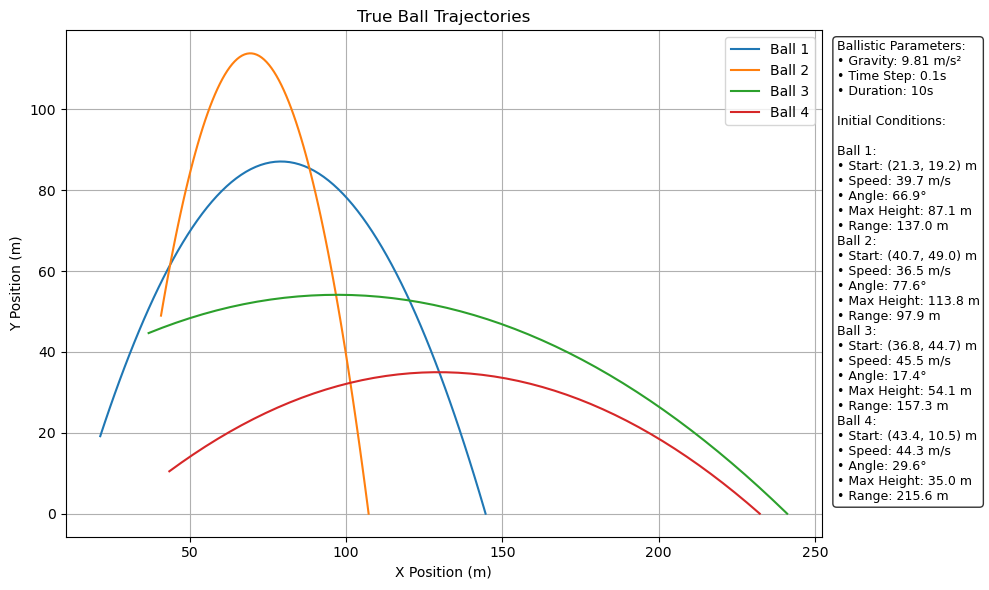

In [80]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap  
import copy  
from scipy.optimize import linear_sum_assignment 
import random 
from matplotlib.lines import Line2D 

# Simulation parameters
gravity = 9.81 
num_balls = 4  # Number of balls to project
time_step = 0.1  # Time period to watch balls
total_duration = 10  # Watch duration of balls
time_array = np.arange(0, total_duration, time_step) 
color_map = matplotlib.colormaps.get_cmap("tab10")

# Generate random initial conditions
np.random.seed(27)  
initial_x_positions = np.random.uniform(0, 50, num_balls)  # Random starting x positions
initial_y_positions = np.random.uniform(0, 50, num_balls)  # Random starting y positions
launch_speeds = np.random.uniform(10, 50, num_balls)  
launch_angles_deg = np.random.uniform(1, 89, num_balls)  
launch_angles_rad = np.deg2rad(launch_angles_deg)  

# Calculate trajectories until balls hit ground
ball_trajectories = [[] for _ in range(num_balls)]  
for ball_idx in range(num_balls):  # Loop through each ball
    current_trajectory = []  
    
    for time_idx in range(1, len(time_array)):  # Iterate through time steps
        prev_time = time_array[time_idx - 1]  
        curr_time = time_array[time_idx]  
        
        # Calculate positions using projectile motion equations
        x_prev = initial_x_positions[ball_idx] + launch_speeds[ball_idx] * np.cos(launch_angles_rad[ball_idx]) * prev_time  # Previous x position
        y_prev = initial_y_positions[ball_idx] + launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx]) * prev_time - 0.5 * gravity * prev_time**2  # Previous y position
        
        x_curr = initial_x_positions[ball_idx] + launch_speeds[ball_idx] * np.cos(launch_angles_rad[ball_idx]) * curr_time  # Current x position
        y_curr = initial_y_positions[ball_idx] + launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx]) * curr_time - 0.5 * gravity * curr_time**2  # Current y position
        
        # Add point if ball is still above ground
        if y_prev >= 0:  # Check if ball hasn't hit ground yet
            current_trajectory.append((x_prev, y_prev))  
        
        # Check if ball crosses ground level
        if y_prev >= 0 and y_curr < 0:  # Ball crosses from above to below ground
            # Find exact landing point using linear interpolation
            ground_intersection_fraction = y_prev / (y_prev - y_curr) 
            landing_x = x_prev + ground_intersection_fraction * (x_curr - x_prev) 
            current_trajectory.append((landing_x, 0.0))  
            break  # Stop tracking this ball
            
    ball_trajectories[ball_idx] = current_trajectory  # Store completed trajectory

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))  

for ball_idx in range(num_balls):  
    trajectory_points = np.array(ball_trajectories[ball_idx])  
    ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], 
            label=f"Ball {ball_idx+1}", color=color_map(ball_idx))

# Information panel
info_panel = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {gravity} m/s²\n"
    f"• Time Step: {time_step}s\n"
    f"• Duration: {total_duration}s\n\n"
    f"Initial Conditions:\n"
)

for ball_idx in range(num_balls): 
    # Calculate theoretical max height and range
    max_height = initial_y_positions[ball_idx] + (launch_speeds[ball_idx]*np.sin(launch_angles_rad[ball_idx]))**2 / (2*gravity)  # Theoretical maximum height
    theoretical_range = initial_x_positions[ball_idx] + (launch_speeds[ball_idx]**2 * np.sin(2*launch_angles_rad[ball_idx])) / gravity  # Theoretical range
    
    info_panel += (  # Ball specific information
        f"\nBall {ball_idx+1}:\n"
        f"• Start: ({initial_x_positions[ball_idx]:.1f}, {initial_y_positions[ball_idx]:.1f}) m\n"
        f"• Speed: {launch_speeds[ball_idx]:.1f} m/s\n"
        f"• Angle: {launch_angles_deg[ball_idx]:.1f}°\n"
        f"• Max Height: {max_height:.1f} m\n"
        f"• Range: {theoretical_range:.1f} m"
    )


ax.text(1.02, 0.98, info_panel, transform=ax.transAxes, 
        fontsize=9, va='top', ha='left', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)) 

# Plot
ax.set_title("True Ball Trajectories") 
ax.set_xlabel("X Position (m)")  
ax.set_ylabel("Y Position (m)")  
ax.grid(True) 
ax.legend() 
plt.tight_layout()  
plt.show() 

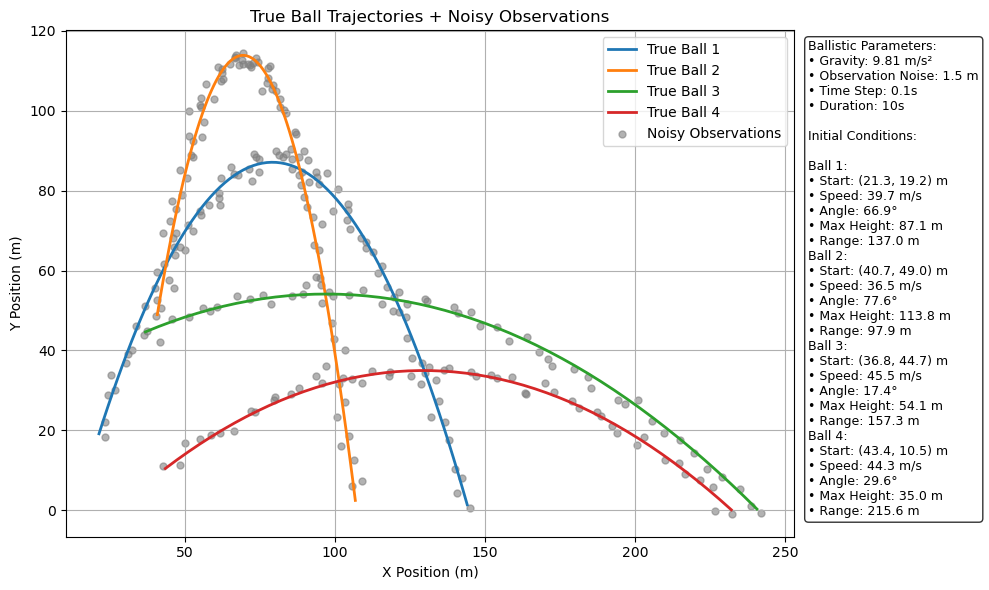

In [81]:
# Generate noisy observations for tracking simulation
noise_standard_deviation = 1.5
noisy_observations = []

for current_time in time_array:
    observations_at_this_time = []
    
    for ball_idx in range(num_balls):
        # Calculate true position at this time
        true_x = initial_x_positions[ball_idx] + launch_speeds[ball_idx] * np.cos(launch_angles_rad[ball_idx]) * current_time
        true_y = initial_y_positions[ball_idx] + launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx]) * current_time - 0.5 * gravity * current_time**2
        
        # Only record observations for balls still above ground
        if true_y >= 0:
            # Adding random noise to simulate measurement errors
            observed_x = true_x + np.random.normal(0, noise_standard_deviation)
            observed_y = true_y + np.random.normal(0, noise_standard_deviation)
            observations_at_this_time.append([observed_x, observed_y])
    
    noisy_observations.append(observations_at_this_time)

# Calculate true trajectories
clean_trajectories = [[] for _ in range(num_balls)]

for current_time in time_array:
    for ball_idx in range(num_balls):
        true_x = initial_x_positions[ball_idx] + launch_speeds[ball_idx] * np.cos(launch_angles_rad[ball_idx]) * current_time
        true_y = initial_y_positions[ball_idx] + launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx]) * current_time - 0.5 * gravity * current_time**2
        
        # Only add points while ball is above ground
        if true_y >= 0:
            clean_trajectories[ball_idx].append((true_x, true_y))

# Comparison plot showing true paths vs noisy observations
fig, ax = plt.subplots(figsize=(10, 6))

# Plot clean true trajectories
for ball_idx in range(num_balls):
    trajectory_points = np.array(clean_trajectories[ball_idx])
    ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], 
            label=f"True Ball {ball_idx+1}", color=color_map(ball_idx), lw=2)

# Plot all noisy observation points
for time_idx, observations_at_time in zip(time_array, noisy_observations):
    if observations_at_time:  # If there are observations at this time
        obs_array = np.array(observations_at_time)
        ax.scatter(obs_array[:, 0], obs_array[:, 1], color="gray", alpha=0.6, s=25, 
                  label="Noisy Observations" if time_idx == 0 else "")

# Update information panel to include noise info
updated_info_panel = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {gravity} m/s²\n"
    f"• Observation Noise: {noise_standard_deviation} m\n"
    f"• Time Step: {time_step}s\n"
    f"• Duration: {total_duration}s\n\n"
    f"Initial Conditions:\n"
)

for ball_idx in range(num_balls):
    max_height = initial_y_positions[ball_idx] + (launch_speeds[ball_idx]*np.sin(launch_angles_rad[ball_idx]))**2 / (2*gravity)
    theoretical_range = initial_x_positions[ball_idx] + (launch_speeds[ball_idx]**2 * np.sin(2*launch_angles_rad[ball_idx])) / gravity
    
    updated_info_panel += (
        f"\nBall {ball_idx+1}:\n"
        f"• Start: ({initial_x_positions[ball_idx]:.1f}, {initial_y_positions[ball_idx]:.1f}) m\n"
        f"• Speed: {launch_speeds[ball_idx]:.1f} m/s\n"
        f"• Angle: {launch_angles_deg[ball_idx]:.1f}°\n"
        f"• Max Height: {max_height:.1f} m\n"
        f"• Range: {theoretical_range:.1f} m"
    )

ax.text(1.02, 0.98, updated_info_panel, transform=ax.transAxes,
        fontsize=9, va='top', ha='left',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

ax.set_title("True Ball Trajectories + Noisy Observations")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


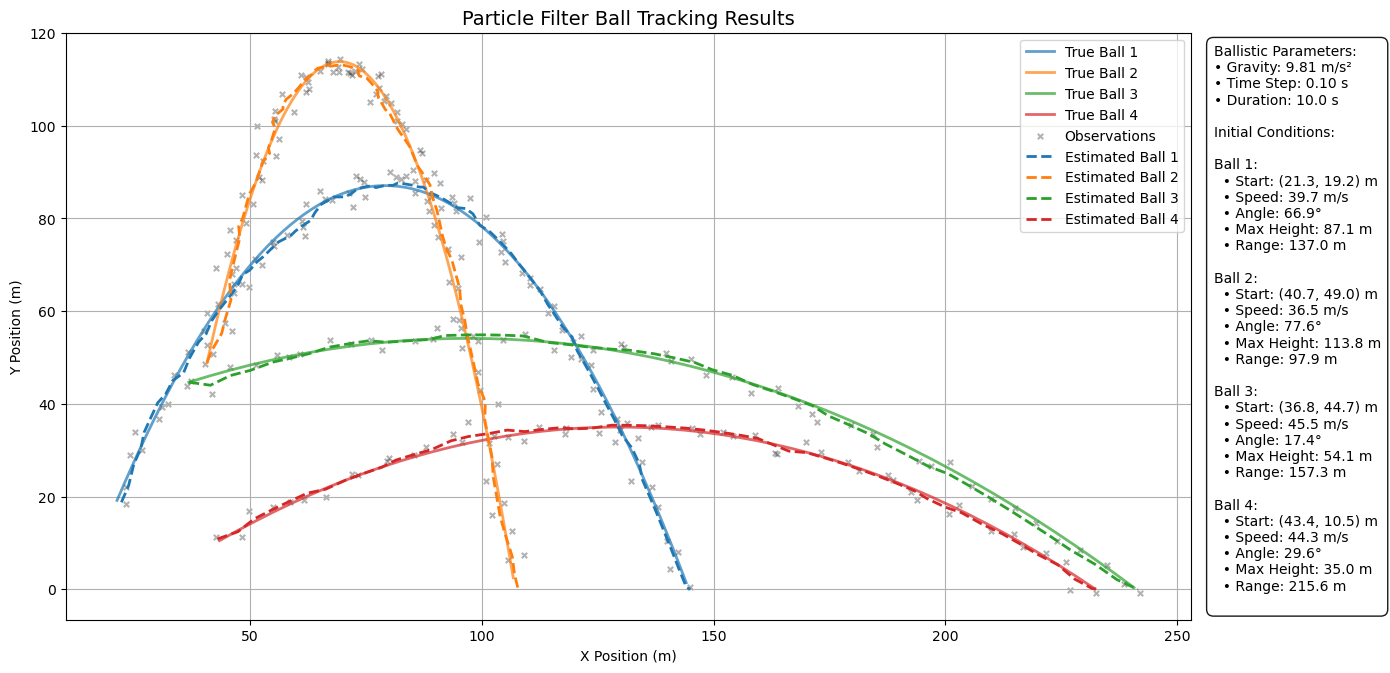

In [82]:
# Particle Filter Implementation for Ball Tracking
num_particles_per_ball = 5000  # Number of particles for each ball

class Particle:
    """Represents a single particle in the particle filter"""
    
    def __init__(self, initial_x, initial_y, initial_velocity_x, initial_velocity_y):
        self.x = initial_x
        self.y = initial_y
        self.velocity_x = initial_velocity_x
        self.velocity_y = initial_velocity_y
        self.has_landed = False
        self.weight = 1.0
    
    def predict_next_state(self, time_step):
        """Update particle position based on physics"""
        if self.has_landed:
            return
        
        # Update position using velocity
        self.x += self.velocity_x * time_step
        self.y += self.velocity_y * time_step - 0.5 * gravity * time_step**2
        self.velocity_y -= gravity * time_step
        
        # Check if particle hits ground
        if self.y <= 0 and self.velocity_y <= 0:
            self.y = 0
            self.velocity_y = 0
            self.has_landed = True
    
    def get_position(self):
        """Return current position as array"""
        return np.array([self.x, self.y])
    
    def copy_particle(self):
        """Create identical copy of this particle"""
        new_particle = Particle(self.x, self.y, self.velocity_x, self.velocity_y)
        new_particle.has_landed = self.has_landed
        new_particle.weight = self.weight
        return new_particle

# Initialize particle filters
initial_position_noise = 1.5
initial_velocity_noise = 1.5
particle_filters = []

for ball_idx in range(num_balls):
    particles_for_this_ball = []
    
    # Calculate true initial velocities
    true_velocity_x = launch_speeds[ball_idx] * np.cos(launch_angles_rad[ball_idx])
    true_velocity_y = launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx])
    
    # Create particles with noise around true initial conditions
    for _ in range(num_particles_per_ball):
        particle = Particle(
            initial_x=np.random.normal(initial_x_positions[ball_idx], initial_position_noise),
            initial_y=np.random.normal(initial_y_positions[ball_idx], initial_position_noise),
            initial_velocity_x=np.random.normal(true_velocity_x, initial_velocity_noise),
            initial_velocity_y=np.random.normal(true_velocity_y, initial_velocity_noise)
        )
        particles_for_this_ball.append(particle)
    
    particle_filters.append(particles_for_this_ball)

def resample_particles(particle_weights, num_particles):
    """Stratified resampling based on particle weights"""
    positions = (np.arange(num_particles) + np.random.random(num_particles)) / num_particles
    cumulative_weights = np.cumsum(particle_weights)
    cumulative_weights[-1] = 1.0
    return np.searchsorted(cumulative_weights, positions)

# Storage for tracking results
estimated_ball_paths = [[] for _ in range(num_balls)]
particle_history = []
mean_position_history = []

# Initial measurement assignment using Hungarian algorithm
first_observations = np.array(noisy_observations[0])
initial_means = []

for particle_filter in particle_filters:
    mean_x = np.mean([particle.x for particle in particle_filter])
    mean_y = np.mean([particle.y for particle in particle_filter])
    initial_means.append([mean_x, mean_y])

initial_means = np.array(initial_means)

# Create cost matrix for assignment
assignment_cost_matrix = np.zeros((num_balls, len(first_observations)))
for ball_idx in range(num_balls):
    for obs_idx in range(len(first_observations)):
        assignment_cost_matrix[ball_idx, obs_idx] = np.linalg.norm(initial_means[ball_idx] - first_observations[obs_idx])

_, observation_assignments = linear_sum_assignment(assignment_cost_matrix)

# Update initial weights based on assignments
for ball_idx in range(num_balls):
    current_filter = particle_filters[ball_idx]
    assigned_observation = first_observations[observation_assignments[ball_idx]]
    
    # Calculate weight for each particle based on distance to observation
    for particle in current_filter:
        distance_to_observation = np.linalg.norm(particle.get_position() - assigned_observation)
        particle.weight = np.exp(-distance_to_observation**2 / (2 * noise_standard_deviation**2))
    
    # Normalize weights
    all_weights = np.array([particle.weight for particle in current_filter])
    total_weight = all_weights.sum()
    
    if total_weight < 1e-10:
        all_weights = np.ones(num_particles_per_ball) / num_particles_per_ball
    else:
        all_weights /= total_weight
    
    # Resample if effective sample size is low
    effective_sample_size = 1.0 / (all_weights**2).sum()
    if effective_sample_size < num_particles_per_ball * 0.7:
        resample_indices = resample_particles(all_weights, num_particles_per_ball)
        resampled_particles = [current_filter[idx].copy_particle() for idx in resample_indices]
        
        # Adding regularization noise to prevent particle depletion
        for particle in resampled_particles:
            if not particle.has_landed:
                particle.x += np.random.normal(0, 0.1 * noise_standard_deviation)
                particle.y += np.random.normal(0, 0.1 * noise_standard_deviation)
                particle.velocity_x += np.random.normal(0, 0.1 * initial_velocity_noise)
                particle.velocity_y += np.random.normal(0, 0.1 * initial_velocity_noise)
            else:
                particle.x += np.random.normal(0, 0.05 * noise_standard_deviation)
        
        particle_filters[ball_idx] = resampled_particles
    else:
        for idx, particle in enumerate(current_filter):
            particle.weight = all_weights[idx]

# Record initial estimates
for ball_idx in range(num_balls):
    current_filter = particle_filters[ball_idx]
    mean_x = np.mean([particle.x for particle in current_filter])
    mean_y = np.mean([particle.y for particle in current_filter])
    estimated_ball_paths[ball_idx].append([time_array[0], mean_x, mean_y])

# Main particle filter tracking loop
for time_step_idx in range(len(time_array) - 1):
    # Predict step: move all particles forward in time
    for particle_filter in particle_filters:
        for particle in particle_filter:
            particle.predict_next_state(time_step)
    
    # Get observations for this time step
    current_observations = (np.array(noisy_observations[time_step_idx + 1]) 
                          if time_step_idx + 1 < len(noisy_observations) 
                          else np.empty((0, 2)))
    
    # Calculate predicted means for assignment
    predicted_means = []
    for particle_filter in particle_filters:
        mean_x = np.mean([particle.x for particle in particle_filter])
        mean_y = np.mean([particle.y for particle in particle_filter])
        predicted_means.append([mean_x, mean_y])
    predicted_means = np.array(predicted_means)
    
    # Assign observations to balls using Hungarian algorithm
    assignment_mapping = {}
    if len(current_observations) > 0:
        active_ball_indices = [i for i in range(num_balls) 
                              if not all(p.has_landed for p in particle_filters[i])]
        
        if len(active_ball_indices) > 0 and len(current_observations) >= len(active_ball_indices):
            cost_matrix = np.zeros((len(active_ball_indices), len(current_observations)))
            for active_idx, ball_idx in enumerate(active_ball_indices):
                for obs_idx in range(len(current_observations)):
                    cost_matrix[active_idx, obs_idx] = np.linalg.norm(
                        predicted_means[ball_idx] - current_observations[obs_idx])
            
            row_indices, col_indices = linear_sum_assignment(cost_matrix)
            assignment_mapping = {active_ball_indices[row_indices[i]]: col_indices[i] 
                                for i in range(len(row_indices))}
    
    current_frame_particles = []
    current_frame_means = []
    
    # Update each particle filter
    for ball_idx in range(num_balls):
        current_filter = particle_filters[ball_idx]
        
        # Update weights if observation is available
        if ball_idx in assignment_mapping:
            assigned_obs = current_observations[assignment_mapping[ball_idx]]
            
            for particle in current_filter:
                distance = np.linalg.norm(particle.get_position() - assigned_obs)
                particle.weight = np.exp(-distance**2 / (2 * noise_standard_deviation**2))
            
            # Normalize and resample if needed
            weights = np.array([particle.weight for particle in current_filter])
            total_weight = weights.sum()
            
            if total_weight < 1e-10:
                weights = np.ones(num_particles_per_ball) / num_particles_per_ball
            else:
                weights /= total_weight
            
            effective_sample_size = 1.0 / (weights**2).sum()
            if effective_sample_size < num_particles_per_ball * 0.7:
                indices = resample_particles(weights, num_particles_per_ball)
                new_particles = [current_filter[idx].copy_particle() for idx in indices]
                
                # Add regularization noise
                for particle in new_particles:
                    if not particle.has_landed:
                        particle.x += np.random.normal(0, 0.1 * noise_standard_deviation)
                        particle.y += np.random.normal(0, 0.1 * noise_standard_deviation)
                        particle.velocity_x += np.random.normal(0, 0.1 * initial_velocity_noise)
                        particle.velocity_y += np.random.normal(0, 0.1 * initial_velocity_noise)
                    else:
                        particle.x += np.random.normal(0, 0.05 * noise_standard_deviation)
                
                particle_filters[ball_idx] = new_particles
            else:
                for idx, particle in enumerate(current_filter):
                    particle.weight = weights[idx]
        
        # Record current state
        current_frame_particles.append(np.array([p.get_position() for p in particle_filters[ball_idx]]))
        mean_x = np.mean([particle.x for particle in particle_filters[ball_idx]])
        mean_y = np.mean([particle.y for particle in particle_filters[ball_idx]])
        current_frame_means.append([mean_x, mean_y])
        estimated_ball_paths[ball_idx].append([time_array[time_step_idx + 1], mean_x, mean_y])
    
    particle_history.append(current_frame_particles)
    mean_position_history.append(current_frame_means)

# Comparison plot
plt.figure(figsize=(14, 8))

# Plot true trajectories
for ball_idx in range(num_balls):
    trajectory = np.array(clean_trajectories[ball_idx])
    if len(trajectory) > 0:
        if trajectory.shape[1] == 3:
            plt.plot(trajectory[:, 1], trajectory[:, 2], 
                    label=f'True Ball {ball_idx+1}', color=color_map(ball_idx), lw=2, alpha=0.7)
        elif trajectory.shape[1] == 2:
            plt.plot(trajectory[:, 0], trajectory[:, 1], 
                    label=f'True Ball {ball_idx+1}', color=color_map(ball_idx), lw=2, alpha=0.7)

# Plot all noisy observations
all_observations = np.concatenate([np.array(obs) for obs in noisy_observations if obs])
plt.scatter(all_observations[:, 0], all_observations[:, 1], color='black', marker='x', 
           alpha=0.3, s=15, label='Observations')

# Plot particle filter estimates
for ball_idx in range(num_balls):
    estimated_trajectory = np.array([point[1:] for point in estimated_ball_paths[ball_idx] if len(point) > 1])
    if len(estimated_trajectory) > 0:
        plt.plot(estimated_trajectory[:, 0], estimated_trajectory[:, 1], '--', 
                label=f'Estimated Ball {ball_idx+1}', color=color_map(ball_idx), lw=2)

# Info panel
final_info_panel = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {gravity:.2f} m/s²\n"
    f"• Time Step: {time_step:.2f} s\n"
    f"• Duration: {total_duration:.1f} s\n\n"
    f"Initial Conditions:\n"
)

for ball_idx in range(num_balls):
    max_height = initial_y_positions[ball_idx] + (launch_speeds[ball_idx] * np.sin(launch_angles_rad[ball_idx]))**2 / (2 * gravity)
    theoretical_range = initial_x_positions[ball_idx] + (launch_speeds[ball_idx]**2 * np.sin(2 * launch_angles_rad[ball_idx])) / gravity
    final_info_panel += (
        f"\nBall {ball_idx+1}:\n"
        f"  • Start: ({initial_x_positions[ball_idx]:.1f}, {initial_y_positions[ball_idx]:.1f}) m\n"
        f"  • Speed: {launch_speeds[ball_idx]:.1f} m/s\n"
        f"  • Angle: {launch_angles_deg[ball_idx]:.1f}°\n"
        f"  • Max Height: {max_height:.1f} m\n"
        f"  • Range: {theoretical_range:.1f} m\n"
    )

plt.gca().text(1.02, 0.98, final_info_panel, transform=plt.gca().transAxes,
              fontsize=10, va='top', ha='left',
              bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.title("Particle Filter Ball Tracking Results", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

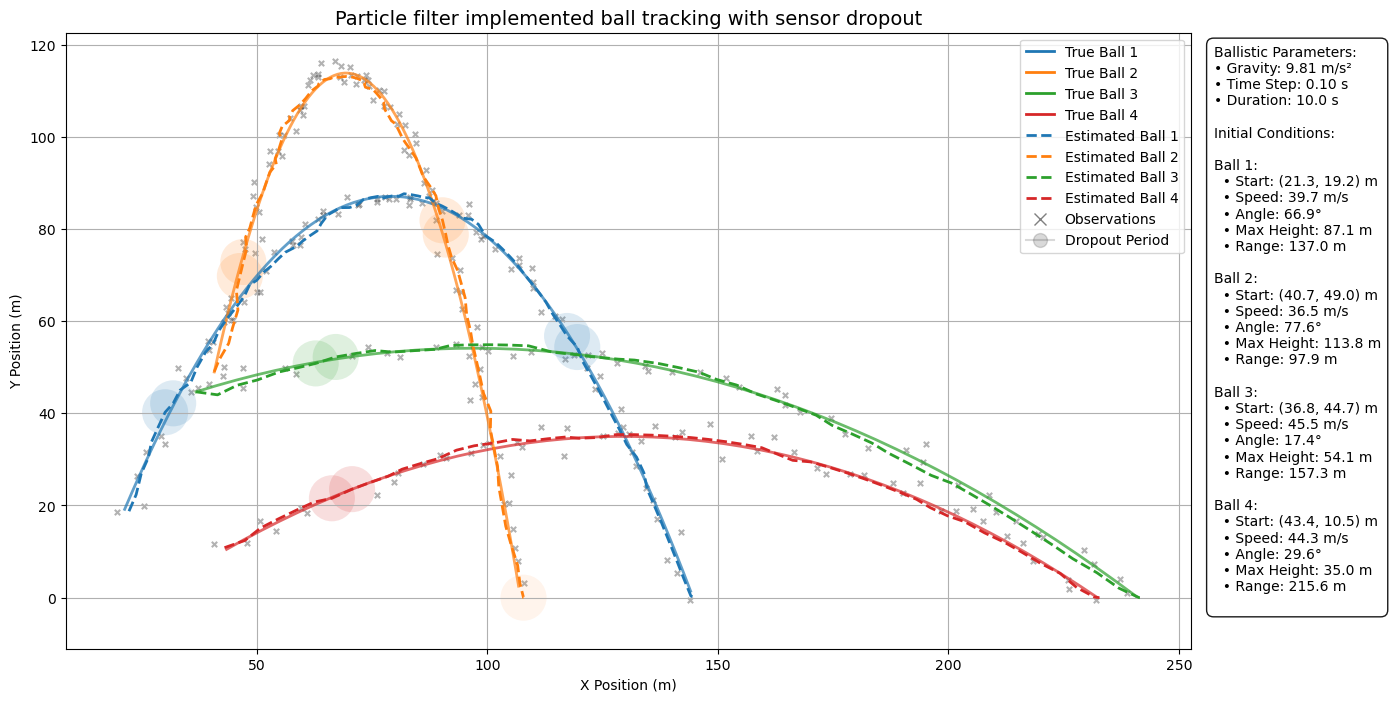

In [83]:
# Parameters for sensor-wide dropout intervals
dropout_length = 2 # How many time steps sensor is offline
max_dropout_start = len(time_array) - dropout_length - 1 

dropout_intervals = []
num_dropouts = 2 # Number of sensor failure periods
for _ in range(num_dropouts):
    start = random.randint(0, max_dropout_start) # Random start time for sensor failure
    dropout_intervals.append(range(start, start + dropout_length)) # Store the dropout period

def is_sensor_dropout(ti_idx):
    # Check if sensor is offline at this time step
    return any(ti_idx in interval for interval in dropout_intervals)

# Parameters for variable observation rate
min_observation_interval_steps = 1 # Minimum time between observations
max_observation_interval_steps = 1 # Maximum time between observations
steps_until_next_observation = 1 # Counter for next observation timing

observations = [] 

# Main loop: generate sensor observations with noise and dropouts
for ti_idx, ti in enumerate(time_array):
    current_true_positions = []
    
    # Calculate true ball positions using projectile motion physics
    for i in range(num_balls):
        # Horizontal position: x = x0 + v*cos(θ)*t
        x_true = initial_x_positions[i] + launch_speeds[i] * np.cos(launch_angles_rad[i]) * ti
        # Vertical position: y = y0 + v*sin(θ)*t - 0.5*g*t²
        y_true = initial_y_positions[i] + launch_speeds[i] * np.sin(launch_angles_rad[i]) * ti - 0.5 * gravity * ti**2
        
        if y_true < 0:
            y_true = 0 # Ball can't go below ground
        current_true_positions.append([x_true, y_true])

    current_obs_at_t = []

    # Skip observations if sensor is offline
    if is_sensor_dropout(ti_idx):
        observations.append([]) # Empty observation during dropout
        continue
        
    # Handle observation timing
    steps_until_next_observation -= 1
    if steps_until_next_observation <= 0:
        # Time to take a measurement
        for i in range(num_balls):
            x_true, y_true = current_true_positions[i]
            if y_true > 0: # Only observe airborne balls
                # Add measurement noise to simulate real sensor
                noisy_x = x_true + np.random.normal(0, noise_standard_deviation)
                noisy_y = y_true + np.random.normal(0, noise_standard_deviation)
                current_obs_at_t.append([noisy_x, noisy_y])
        
        observations.append(current_obs_at_t)
        # Set next observation time (could be random)
        steps_until_next_observation = random.randint(min_observation_interval_steps, max_observation_interval_steps)
    else:
        observations.append([]) # No observation this time step

# Visualization plot
plt.figure(figsize=(14, 8))

# Plot the true ball trajectories
for i in range(num_balls):
    traj = np.array(clean_trajectories[i])
    if len(traj) > 0:
        # Handle different data formats
        if traj.shape[1] == 3: # Format: (time, x, y)
            plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=color_map(i), lw=2, alpha=0.7)
        elif traj.shape[1] == 2: # Format: (x, y)
            plt.plot(traj[:, 0], traj[:, 1], label=f'True Ball {i+1}', color=color_map(i), lw=2, alpha=0.7)

# Plot the noisy sensor observations
all_obs_x = []
all_obs_y = []
for time_idx, obs_list_at_t in enumerate(observations):
    if len(obs_list_at_t) > 0: # Only process non-empty observations
        for obs_point in obs_list_at_t:
            all_obs_x.append(obs_point[0]) # Extract x coordinates
            all_obs_y.append(obs_point[1]) # Extract y coordinates

if all_obs_x:
    plt.scatter(all_obs_x, all_obs_y, color='black', marker='x', alpha=0.3, s=15, label='Observations')

# Plot the estimated trajectories from particle filter
for i in range(num_balls):
    # Extract position estimates (skip time stamps)
    est_traj = np.array([point[1:] for point in estimated_ball_paths[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=color_map(i), lw=2)

        # Add visual indicators for problematic periods
        for traj_idx, (x_est, y_est) in enumerate(est_traj):
            if y_est <= 0:
                continue  # Skip landed balls
            
            # Mark sensor dropout periods with darker circles
            if traj_idx < len(time_array) and is_sensor_dropout(traj_idx):
                circle = plt.Circle((x_est, y_est), radius=5, color=color_map(i), alpha=0.15, lw=0)
                plt.gca().add_patch(circle)
            # Mark missing observations with lighter circles
            elif traj_idx < len(time_array) and len(observations[traj_idx]) == 0 and not is_sensor_dropout(traj_idx):
                circle = plt.Circle((x_est, y_est), radius=5, color=color_map(i), alpha=0.08, lw=0)
                plt.gca().add_patch(circle)

info_text = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {gravity:.2f} m/s²\n"
    f"• Time Step: {time_step:.2f} s\n"
    f"• Duration: {total_duration:.1f} s\n\n"
    f"Initial Conditions:\n"
)

for i in range(num_balls):
    max_height = initial_y_positions[i] + (launch_speeds[i] * np.sin(launch_angles_rad[i]))**2 / (2 * gravity)
    range_est = initial_x_positions[i] + (launch_speeds[i]**2 * np.sin(2 * launch_angles_rad[i])) / gravity
    info_text += (
        f"\nBall {i+1}:\n"
        f"  • Start: ({initial_x_positions[i]:.1f}, {initial_y_positions[i]:.1f}) m\n"
        f"  • Speed: {launch_speeds[i]:.1f} m/s\n"
        f"  • Angle: {launch_angles_deg[i]:.1f}°\n"
        f"  • Max Height: {max_height:.1f} m\n"
        f"  • Range: {range_est:.1f} m\n"
    )

plt.gca().text(1.02, 0.98, info_text, transform=plt.gca().transAxes,
               fontsize=10, va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.title("Particle filter implemented ball tracking with sensor dropout", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")

legend_elements = []
# Add true trajectory lines
for i in range(num_balls):
    legend_elements.append(Line2D([0], [0], color=color_map(i), lw=2, label=f'True Ball {i+1}'))
# Add estimated trajectory lines
for i in range(num_balls):
    legend_elements.append(Line2D([0], [0], linestyle='--', color=color_map(i), lw=2, label=f'Estimated Ball {i+1}'))
# Add observation markers
legend_elements.append(Line2D([0], [0], marker='x', color='grey', lw=0, label='Observations', markersize=8))
# Add dropout indicator
legend_elements.append(Line2D([0], [0], marker='o', color='black', markerfacecolor='black',
                              markersize=10, alpha=0.15, label='Dropout Period'))

plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.legend(handles=legend_elements, fontsize=10, loc='upper right')
ax = plt.gca()
ax.grid(True)
plt.show()

In [84]:
#Variable time step 

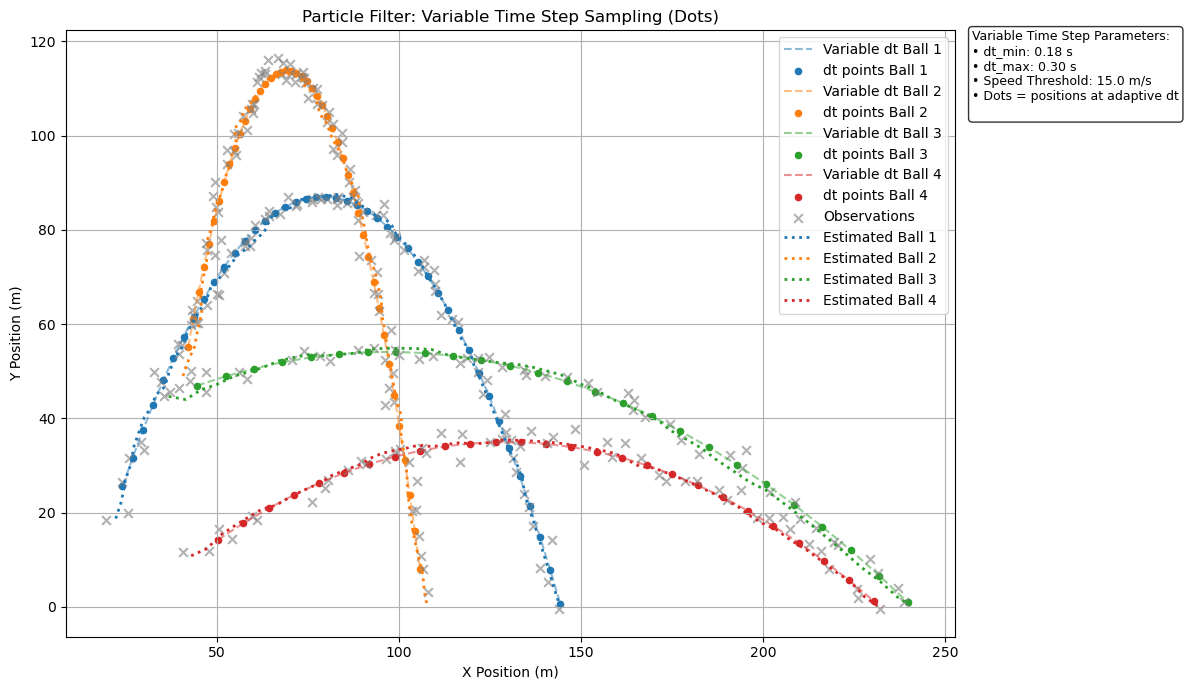

In [85]:
# Initialize adaptive trajectory storage for each ball
adaptive_trajectories = [[] for _ in range(num_balls)]

# Adaptive time step parameters
dt_min = 0.18 # Minimum time step for fast-moving balls
dt_max = 0.3 # Maximum time step for slow-moving balls
v_thresh = 15.0  # Speed threshold to switch between time steps

# Visual styling for different balls
marker_styles = ['o', 's', '^'] # Circle, square, triangle markers

# Simulate ball trajectories with adaptive time stepping
for i in range(num_balls):
    # Initialize ball state
    x = initial_x_positions[i] # Starting x position
    y = initial_y_positions[i] # Starting y position
    vx = launch_speeds[i] * np.cos(launch_angles_rad[i]) # Initial horizontal velocity
    vy = launch_speeds[i] * np.sin(launch_angles_rad[i]) # Initial vertical velocity
    
    t_adaptive = 0.0 # Track elapsed time with adaptive steps
    
    # Simulate until ball hits ground or time runs out
    while y >= 0 and t_adaptive < total_duration:
        speed = np.sqrt(vx**2 + vy**2) # Calculate current ball speed
        
        # Choose time step based on ball speed (faster = smaller dt)
        dt_var = dt_min + (dt_max - dt_min) * np.clip(1 - launch_speeds[i] / v_thresh, 0, 1)
        
        # Update ball position using physics
        x += vx * dt_var # Move horizontally
        y += vy * dt_var - 0.5 * gravity * dt_var**2 # Move vertically with gravity
        vy -= gravity * dt_var # Update vertical velocity due to gravity
        
        # Store position if ball is still airborne
        if y >= 0:
            adaptive_trajectories[i].append((x, y, dt_var))
        
        t_adaptive += dt_var # Advance simulation time

fig, ax = plt.subplots(figsize=(12, 7))

# Plot adaptive time step trajectories with connecting lines
for i in range(num_balls):
    traj_adapt = np.array(adaptive_trajectories[i])
    # Draw dashed line connecting adaptive points
    ax.plot(traj_adapt[:, 0], traj_adapt[:, 1], linestyle='--', color=color_map(i), alpha=0.5, label=f"Variable dt Ball {i+1}")
    # Show individual sampling points as dots
    ax.scatter(traj_adapt[:, 0], traj_adapt[:, 1], color=color_map(i), s=20, label=f"dt points Ball {i+1}")

# Plot sensor observations as gray X marks
for ti, obs in zip(time_array, observations):
    if obs:  # Only plot if observations exist at this time
        obs = np.array(obs)
        ax.scatter(obs[:, 0], obs[:, 1], marker='x', color="gray", alpha=0.6, s=40, 
                  label="Observations" if ti == 0 else "") # Label only once

# Plot particle filter estimates as dotted lines
for i in range(num_balls):
    # Extract position estimates (skip time stamps)
    est_traj = np.array([point[1:] for point in estimated_ball_paths[i]])
    ax.plot(est_traj[:, 0], est_traj[:, 1], color=color_map(i), linestyle=':', lw=2, 
           label=f"Estimated Ball {i+1}")

info_text = (
    f"Variable Time Step Parameters:\n"
    f"• dt_min: {dt_min:.2f} s\n"
    f"• dt_max: {dt_max:.2f} s\n"
    f"• Speed Threshold: {v_thresh:.1f} m/s\n"
    f"• Dots = positions at adaptive dt\n"
)

ax.text(1.02, 1.0, info_text, transform=ax.transAxes,
        fontsize=9, va='top', ha='left',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Set plot labels and formatting
ax.set_title("Particle Filter: Variable Time Step Sampling (Dots)")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.legend() # Show legend with all trajectory types
ax.grid(True) # Add grid for easier reading
plt.tight_layout() # Optimize layout spacing
plt.show()

In [86]:
# Velocity Components and Speed graphs with respect to Time

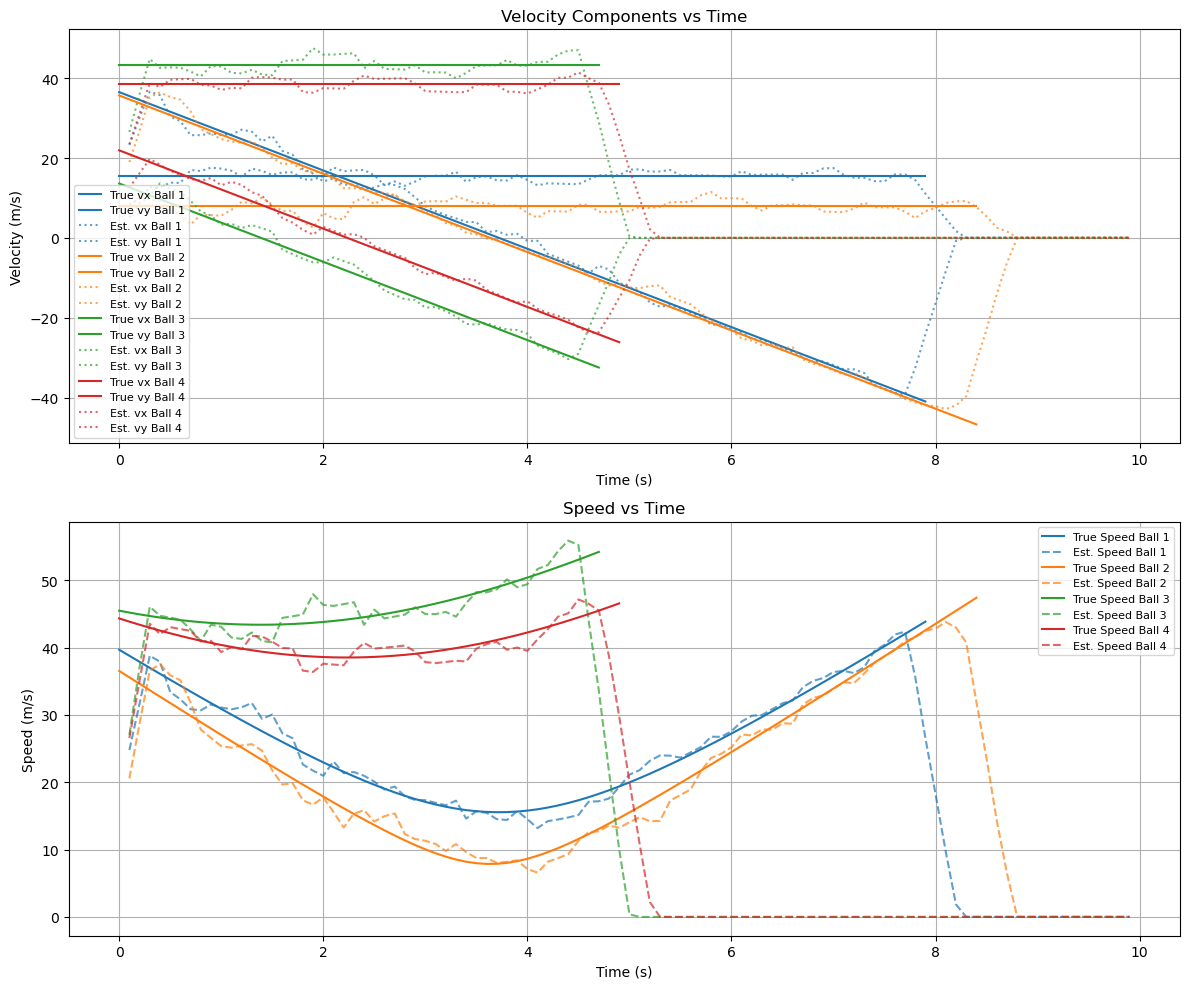

In [87]:
# Import smoothing filter for velocity calculations
from scipy.ndimage import uniform_filter1d

fig, (ax_vel, ax_speed) = plt.subplots(2, 1, figsize=(12, 10))

for i in range(num_balls):
    # Calculate true velocity components from physics equations
    true_times = []
    true_vxs, true_vys, true_speeds = [], [], []
    
    for ti in time_array:
        # Check if ball is still in air
        y = initial_y_positions[i] + launch_speeds[i] * np.sin(launch_angles_rad[i]) * ti - 0.5 * gravity * ti**2
        if y < 0: break # Stop when ball hits ground
        
        # Calculate true velocities from physics
        vx = launch_speeds[i] * np.cos(launch_angles_rad[i]) # Horizontal velocity (constant)
        vy = launch_speeds[i] * np.sin(launch_angles_rad[i]) - gravity * ti # Vertical velocity (decreases)
        speed = np.sqrt(vx**2 + vy**2) 
        
        # Store values for plotting
        true_times.append(ti)
        true_vxs.append(vx)
        true_vys.append(vy)
        true_speeds.append(speed)
    
    # Plot true velocity components
    ax_vel.plot(true_times, true_vxs, color=color_map(i), linestyle='-', label=f'True vx Ball {i+1}')
    ax_vel.plot(true_times, true_vys, color=color_map(i), linestyle='-', label=f'True vy Ball {i+1}')
    ax_speed.plot(true_times, true_speeds, color=color_map(i), linestyle='-', label=f'True Speed Ball {i+1}')
    
    # Extract estimated trajectory data from particle filter
    est_times = np.array([p[0] for p in estimated_ball_paths[i]]) # Time stamps
    est_xs = np.array([p[1] for p in estimated_ball_paths[i]]) # X positions
    est_ys = np.array([p[2] for p in estimated_ball_paths[i]]) # Y positions
    
    # Smooth estimated positions to reduce noise before taking derivatives
    smooth_x = uniform_filter1d(est_xs, size=5, mode='nearest') # 5-point moving average
    smooth_y = uniform_filter1d(est_ys, size=5, mode='nearest')
    
    # Calculate estimated velocities using numerical differentiation
    vx_est, vy_est, speed_est = [], [], []
    for k in range(1, len(smooth_x)):
        dt_est = est_times[k] - est_times[k-1] # Time difference between points
        if dt_est <= 0: continue # Skip invalid time steps
        
        # Velocity = change in position / change in time
        vx = (smooth_x[k] - smooth_x[k-1]) / dt_est # Horizontal velocity estimate
        vy = (smooth_y[k] - smooth_y[k-1]) / dt_est # Vertical velocity estimate
        
        vx_est.append(vx)
        vy_est.append(vy)
        speed_est.append(np.sqrt(vx**2 + vy**2)) # Speed magnitude
    
    # Time points for estimated velocities (shifted by half step)
    est_times_valid = est_times[1:len(vx_est)+1]
    
    # Plot estimated velocity components
    ax_vel.plot(est_times_valid, vx_est, color=color_map(i), linestyle=':', alpha=0.7, label=f'Est. vx Ball {i+1}')
    ax_vel.plot(est_times_valid, vy_est, color=color_map(i), linestyle=':', alpha=0.7, label=f'Est. vy Ball {i+1}')
    ax_speed.plot(est_times_valid, speed_est, color=color_map(i), linestyle='--', alpha=0.7, label=f'Est. Speed Ball {i+1}')

ax_vel.set_title('Velocity Components vs Time')
ax_vel.set_xlabel('Time (s)')
ax_vel.set_ylabel('Velocity (m/s)')
ax_vel.grid(True)
ax_vel.legend(fontsize=8, loc='best')

ax_speed.set_title('Speed vs Time')
ax_speed.set_xlabel('Time (s)')
ax_speed.set_ylabel('Speed (m/s)')
ax_speed.grid(True)
ax_speed.legend(fontsize=8, loc='best')
plt.tight_layout()
plt.show()